# 🧠 MindGuard AI - Demo Notebook

This notebook demonstrates the complete pipeline for the MindGuard AI mental health text classifier.

## Contents
1. Setup & Installation
2. Data Preprocessing
3. Model Training
4. Evaluation & Visualization
5. Inference Demo


## 1. Setup & Installation


In [17]:
# Install dependencies
%pip install nltk contractions unidecode emoji --quiet


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
import sys
import os
from pathlib import Path

# Add parent directory to path
project_root = Path(os.getcwd()).parent
sys.path.insert(0, str(project_root))

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer
from sklearn.metrics import classification_report, confusion_matrix

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")


PyTorch version: 2.9.1+cpu
CUDA available: False
Device: cpu


## 2. Data Preprocessing


In [19]:
from data.preprocessing import (
    TextPreprocessor, 
    create_synthetic_dataset, 
    load_and_prepare_data,
    LABEL_MAP
)

# Initialize preprocessor
preprocessor = TextPreprocessor()

# Create synthetic dataset
print("Creating synthetic mental health dataset...")
df = create_synthetic_dataset(n_samples=2000)

print(f"\nDataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()



Creating synthetic mental health dataset...

Dataset shape: (2000, 2)

Columns: ['text', 'label']


,text,label
0,Looking up ways to end my life.,3
1,Looking forward to the weekend plans.,0
2,I feel worthless and undeserving of love. Why me?,2
3,A bit anxious about the upcoming deadline. Hmm.,1
4,Every day feels like an endless struggle.,2


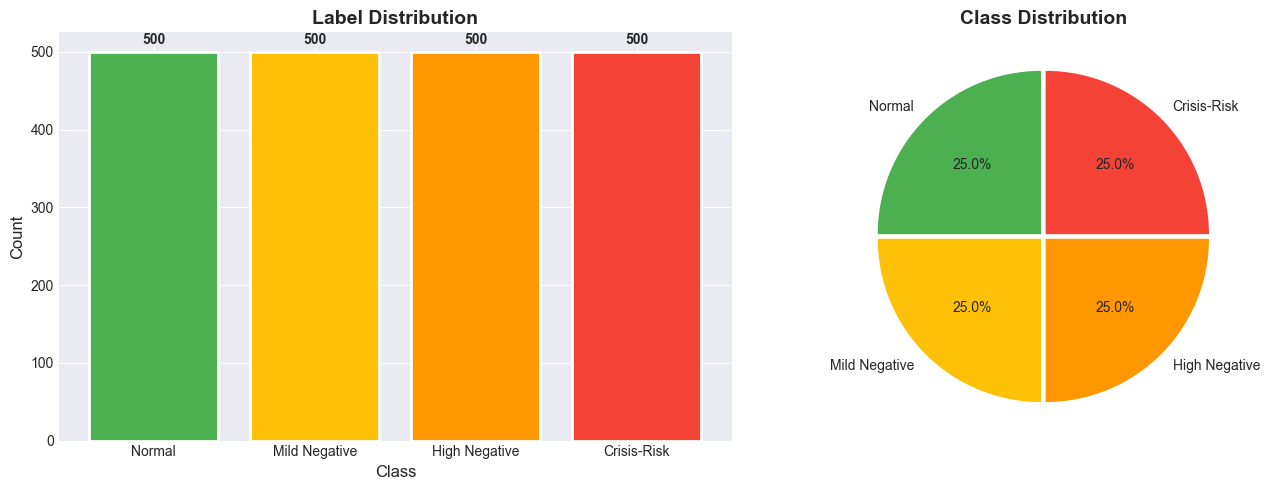

In [20]:
# Label distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
label_counts = df['label'].value_counts().sort_index()
colors = ['#4CAF50', '#FFC107', '#FF9800', '#F44336']
labels = [LABEL_MAP[i] for i in range(4)]

axes[0].bar(labels, label_counts.values, color=colors, edgecolor='white', linewidth=2)
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Label Distribution', fontsize=14, fontweight='bold')
for i, v in enumerate(label_counts.values):
    axes[0].text(i, v + 10, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(label_counts.values, labels=labels, colors=colors, autopct='%1.1f%%',
            startangle=90, explode=[0.02]*4)
axes[1].set_title('Class Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../data/label_distribution.png', dpi=150, bbox_inches='tight')
plt.show()


In [21]:
# Test preprocessing
test_texts = [
    "I'm feeling really hopeless today... 😢 https://example.com @friend",
    "Had a great day! Everything is wonderful 🌟",
    "I want to hurt myself, I can't take it anymore",
    "Feeling a bit stressed about work but managing okay."
]

print("Preprocessing Examples:\n" + "="*60)
for text in test_texts:
    cleaned = preprocessor.clean_text(text)
    indicators = preprocessor.detect_crisis_indicators(text)
    print(f"\nOriginal: {text}")
    print(f"Cleaned: {cleaned}")
    print(f"Crisis indicators: {indicators['crisis_indicators']}")
    print("-"*60)


Preprocessing Examples:

Original: I'm feeling really hopeless today... 😢 https://example.com @friend
Cleaned: i am feeling really hopeless today ...
Crisis indicators: []
------------------------------------------------------------

Original: Had a great day! Everything is wonderful 🌟
Cleaned: had a great day ! everything is wonderful
Crisis indicators: []
------------------------------------------------------------

Original: I want to hurt myself, I can't take it anymore
Cleaned: i want to hurt myself , i can not take it anymore
Crisis indicators: ['hurt myself']
------------------------------------------------------------

Original: Feeling a bit stressed about work but managing okay.
Cleaned: feeling a bit stressed about work but managing okay .
Crisis indicators: []
------------------------------------------------------------


## 3. Model Training


In [22]:
from model.classifier import MindGuardClassifier
from data.dataset import create_data_loaders

# Configuration
MODEL_NAME = "distilbert-base-uncased"
MAX_LENGTH = 256
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 2e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training device: {device}")


Training device: cpu


In [23]:
# Preprocess dataframe
df_processed = preprocessor.preprocess_dataframe(df)
print(f"Processed samples: {len(df_processed)}")

# Split data
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df_processed, test_size=0.3, random_state=42, stratify=df_processed['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


Processed samples: 2000
Train: 1400, Val: 300, Test: 300


In [24]:
# Initialize tokenizer and data loaders
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_loader, val_loader, test_loader = create_data_loaders(
    train_df, val_df, test_df,
    tokenizer,
    batch_size=BATCH_SIZE,
    max_length=MAX_LENGTH
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\jalal\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jalal\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Train batches: 88
Val batches: 19
Test batches: 19


In [25]:
# Initialize model
model = MindGuardClassifier(
    model_name=MODEL_NAME,
    num_classes=4,
    dropout_rate=0.3
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Total parameters: 66,659,716
Trainable parameters: 66,659,716


In [26]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

# Optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

# Scheduler
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=100,
    num_training_steps=total_steps
)

# Training history
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}


In [27]:
# Training loop
print("Starting training...\n")

for epoch in range(EPOCHS):
    # Training
    model.train()
    train_loss = 0
    train_preds, train_labels = [], []
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for batch in progress_bar:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask, labels)
        loss = outputs['loss']
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
        preds = torch.argmax(outputs['logits'], dim=-1).cpu().numpy()
        train_preds.extend(preds)
        train_labels.extend(labels.cpu().numpy())
        
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Validation
    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask, labels)
            val_loss += outputs['loss'].item()
            
            preds = torch.argmax(outputs['logits'], dim=-1).cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    train_acc = accuracy_score(train_labels, train_preds)
    val_acc = accuracy_score(val_labels, val_preds)
    
    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss / len(val_loader))
    history['val_acc'].append(val_acc)
    
    print(f"\nEpoch {epoch+1}: Train Loss={train_loss/len(train_loader):.4f}, "
          f"Train Acc={train_acc:.4f}, Val Loss={val_loss/len(val_loader):.4f}, Val Acc={val_acc:.4f}")

print("\nTraining complete!")


Starting training...



Epoch 1/3:   0%|          | 0/88 [00:00<?, ?it/s]

c:\Users\jalal\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Epoch 1: Train Loss=1.1639, Train Acc=0.4900, Val Loss=0.1118, Val Acc=0.9967


Epoch 2/3:   0%|          | 0/88 [00:00<?, ?it/s]

c:\Users\jalal\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Epoch 2: Train Loss=0.0292, Train Acc=0.9943, Val Loss=0.0001, Val Acc=1.0000


Epoch 3/3:   0%|          | 0/88 [00:00<?, ?it/s]

c:\Users\jalal\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Epoch 3: Train Loss=0.0007, Train Acc=1.0000, Val Loss=0.0001, Val Acc=1.0000

Training complete!


## 4. Evaluation & Visualization


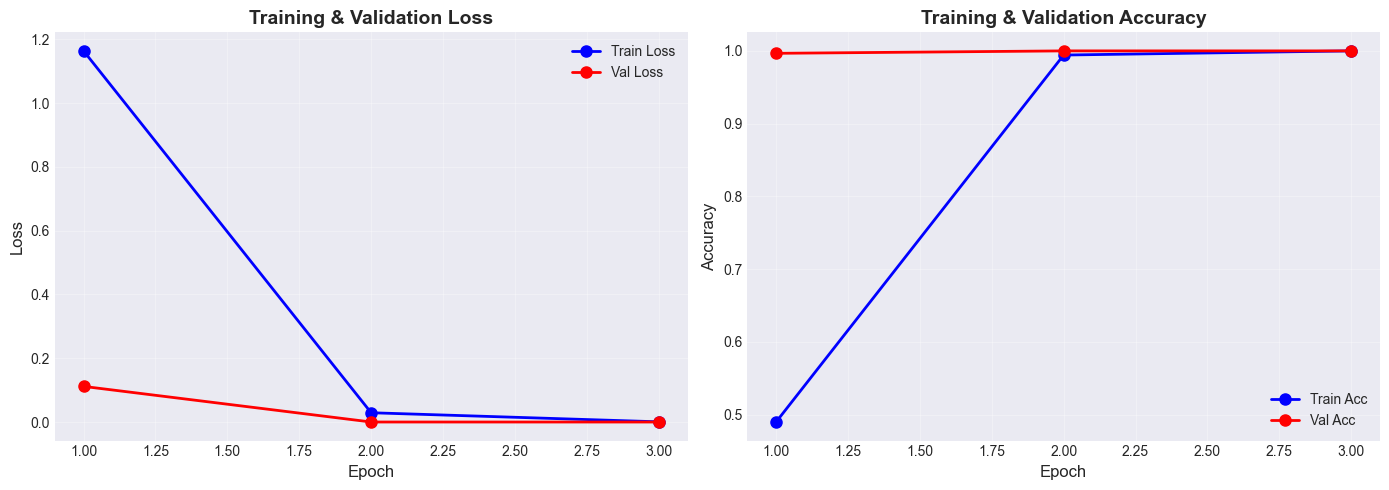

In [28]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, len(history['train_loss']) + 1)

# Loss
axes[0].plot(epochs_range, history['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=8)
axes[0].plot(epochs_range, history['val_loss'], 'r-o', label='Val Loss', linewidth=2, markersize=8)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(epochs_range, history['train_acc'], 'b-o', label='Train Acc', linewidth=2, markersize=8)
axes[1].plot(epochs_range, history['val_acc'], 'r-o', label='Val Acc', linewidth=2, markersize=8)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()


In [29]:
# Test set evaluation
model.eval()
test_preds, test_labels, test_probs = [], [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask)
        
        preds = torch.argmax(outputs['logits'], dim=-1).cpu().numpy()
        probs = outputs['probabilities'].cpu().numpy()
        
        test_preds.extend(preds)
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probs)

# Classification report
print("\nClassification Report:\n")
print(classification_report(test_labels, test_preds, target_names=[LABEL_MAP[i] for i in range(4)]))


Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

c:\Users\jalal\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Classification Report:

               precision    recall  f1-score   support

       Normal       1.00      1.00      1.00        75
Mild Negative       1.00      1.00      1.00        75
High Negative       1.00      1.00      1.00        75
  Crisis-Risk       1.00      1.00      1.00        75

     accuracy                           1.00       300
    macro avg       1.00      1.00      1.00       300
 weighted avg       1.00      1.00      1.00       300



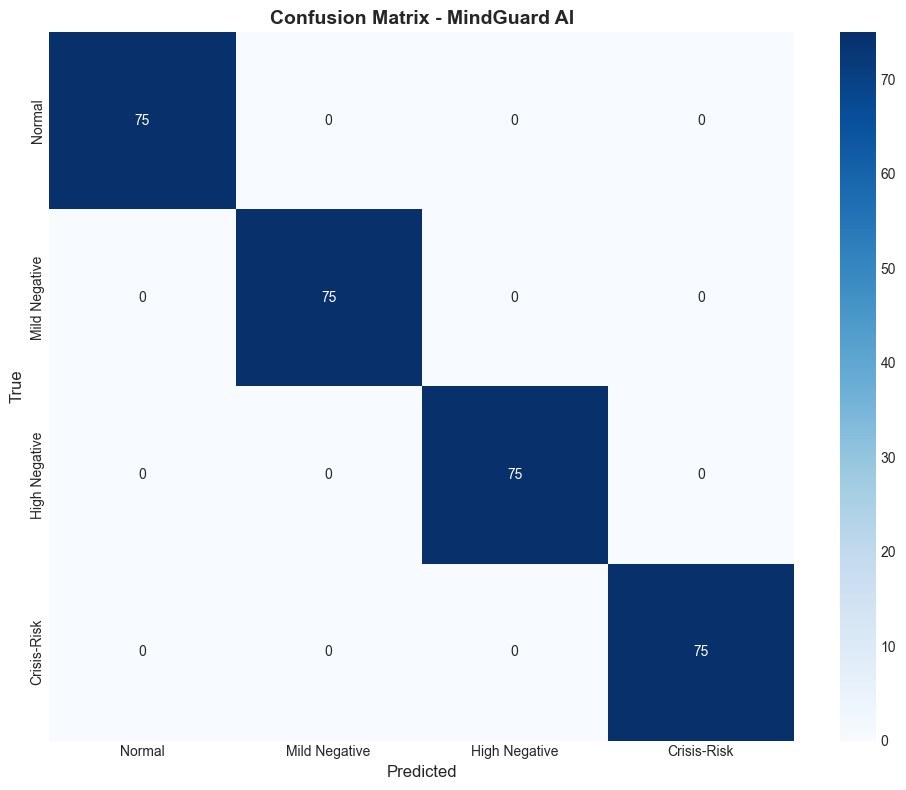

In [30]:
# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[LABEL_MAP[i] for i in range(4)],
            yticklabels=[LABEL_MAP[i] for i in range(4)])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Confusion Matrix - MindGuard AI', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../data/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()


## 5. Inference Demo


In [31]:
def predict_text(text: str, model, tokenizer, device, preprocessor):
    """Make prediction for a single text."""
    model.eval()
    
    # Preprocess
    cleaned = preprocessor.clean_text(text)
    indicators = preprocessor.detect_crisis_indicators(text)
    
    # Tokenize
    inputs = tokenizer(
        cleaned,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=256
    ).to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(inputs['input_ids'], inputs['attention_mask'])
        probs = outputs['probabilities'][0].cpu().numpy()
        pred_class = np.argmax(probs)
    
    # Override if crisis keywords detected
    if indicators['has_crisis_content']:
        pred_class = 3
    
    return {
        'text': text,
        'cleaned': cleaned,
        'class_id': pred_class,
        'class_label': LABEL_MAP[pred_class],
        'confidence': probs[pred_class],
        'probabilities': {LABEL_MAP[i]: probs[i] for i in range(4)},
        'crisis_indicators': indicators['crisis_indicators']
    }


In [32]:
# Test predictions
test_samples = [
    "I had a wonderful day at work and I'm feeling great!",
    "I'm feeling a bit stressed about my exams coming up.",
    "I feel so hopeless and worthless. Nothing matters anymore.",
    "I want to end my life. Nobody would care if I was gone.",
    "Just got back from vacation, feeling refreshed and happy!",
    "My depression has been getting worse. I hate myself."
]

print("="*80)
print("INFERENCE DEMO - MindGuard AI")
print("="*80)

for text in test_samples:
    result = predict_text(text, model, tokenizer, device, preprocessor)
    
    print(f"\n📝 Text: {text}")
    print(f"🏷️  Classification: {result['class_label']}")
    print(f"📊 Confidence: {result['confidence']*100:.1f}%")
    if result['crisis_indicators']:
        print(f"⚠️  Crisis indicators: {result['crisis_indicators']}")
    print("-"*80)


INFERENCE DEMO - MindGuard AI

📝 Text: I had a wonderful day at work and I'm feeling great!
🏷️  Classification: Normal
📊 Confidence: 93.1%
--------------------------------------------------------------------------------

📝 Text: I'm feeling a bit stressed about my exams coming up.
🏷️  Classification: High Negative
📊 Confidence: 99.9%
--------------------------------------------------------------------------------

📝 Text: I feel so hopeless and worthless. Nothing matters anymore.
🏷️  Classification: High Negative
📊 Confidence: 100.0%
--------------------------------------------------------------------------------

📝 Text: I want to end my life. Nobody would care if I was gone.
🏷️  Classification: Crisis-Risk
📊 Confidence: 100.0%
⚠️  Crisis indicators: ['end my life']
--------------------------------------------------------------------------------

📝 Text: Just got back from vacation, feeling refreshed and happy!
🏷️  Classification: Normal
📊 Confidence: 100.0%
--------------------------


INTERACTIVE PREDICTION


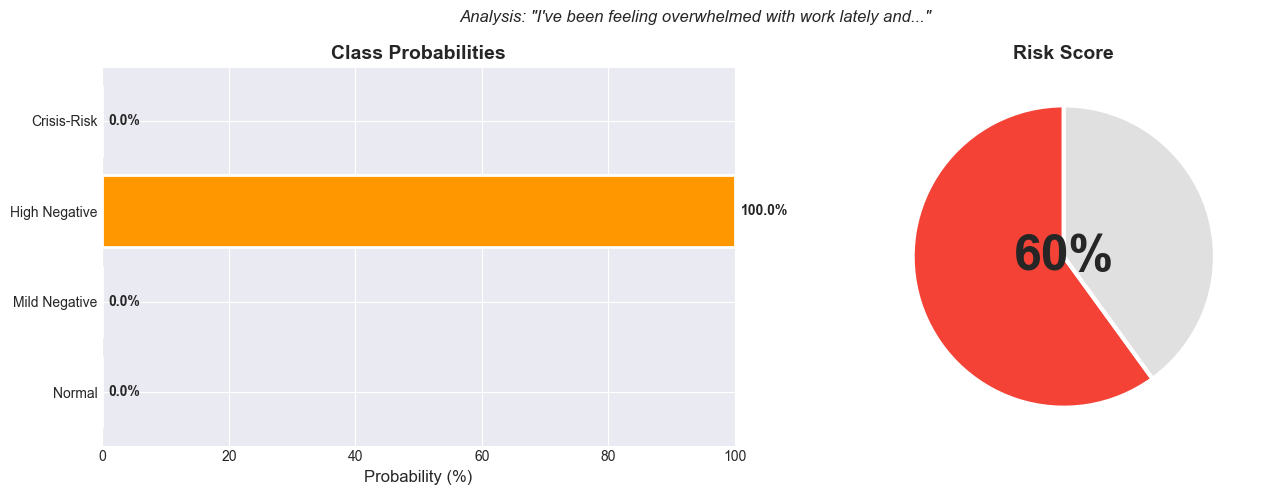


📊 Prediction: High Negative (100.0% confidence)
⚡ Risk Score: 60%


In [33]:
# Interactive prediction with visualization
print("\n" + "="*80)
print("INTERACTIVE PREDICTION")
print("="*80)

# You can change this text to test different inputs
user_text = "I've been feeling overwhelmed with work lately and it's affecting my sleep."

result = predict_text(user_text, model, tokenizer, device, preprocessor)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Probability bar chart
labels_list = list(result['probabilities'].keys())
values = [v * 100 for v in result['probabilities'].values()]
colors = ['#4CAF50', '#FFC107', '#FF9800', '#F44336']

bars = axes[0].barh(labels_list, values, color=colors, edgecolor='white', linewidth=2)
axes[0].set_xlabel('Probability (%)', fontsize=12)
axes[0].set_title('Class Probabilities', fontsize=14, fontweight='bold')
axes[0].set_xlim(0, 100)

for bar, v in zip(bars, values):
    axes[0].text(v + 1, bar.get_y() + bar.get_height()/2, f'{v:.1f}%', va='center', fontweight='bold')

# Risk gauge (pie chart style)
risk_score = sum(result['probabilities'][LABEL_MAP[i]] * [0, 0.25, 0.6, 1.0][i] for i in range(4))

axes[1].pie([risk_score, 1-risk_score], colors=['#F44336', '#E0E0E0'], startangle=90,
            wedgeprops={'linewidth': 3, 'edgecolor': 'white'})
axes[1].text(0, 0, f'{risk_score*100:.0f}%', ha='center', va='center', fontsize=36, fontweight='bold')
axes[1].set_title('Risk Score', fontsize=14, fontweight='bold')

plt.suptitle(f'Analysis: "{user_text[:50]}..."', fontsize=12, style='italic')
plt.tight_layout()
plt.show()

print(f"\n📊 Prediction: {result['class_label']} ({result['confidence']*100:.1f}% confidence)")
print(f"⚡ Risk Score: {risk_score*100:.0f}%")


## 6. Save Model for Deployment


In [34]:
# Save model
import json

save_dir = project_root / "checkpoints" / "notebook_model"
save_dir.mkdir(parents=True, exist_ok=True)

# Save model weights
torch.save(model.state_dict(), save_dir / "pytorch_model.bin")

# Save tokenizer
tokenizer.save_pretrained(save_dir)

# Save config
config = {
    'model_name': MODEL_NAME,
    'num_classes': 4,
    'labels': LABEL_MAP,
    'max_length': MAX_LENGTH,
    'final_val_accuracy': history['val_acc'][-1]
}

with open(save_dir / "config.json", 'w') as f:
    json.dump(config, f, indent=2)

print(f"Model saved to: {save_dir}")


Model saved to: c:\Users\jalal\mindguard-ai\checkpoints\notebook_model


---

## 🎉 Demo Complete!

You've successfully:
1. ✅ Created and preprocessed a mental health dataset
2. ✅ Trained a DistilBERT classifier
3. ✅ Evaluated model performance
4. ✅ Made predictions on new text
5. ✅ Saved the model for deployment

### Next Steps:
- Start the FastAPI backend: `cd api && python main.py`
- Launch the Streamlit UI: `cd frontend && streamlit run app.py`

### ⚠️ Important Disclaimer
This model is for educational purposes only. Mental health classification is a sensitive task that requires professional expertise. Always consult mental health professionals for actual diagnosis and treatment.
